In [157]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import scipy.misc
from skimage.morphology import flood

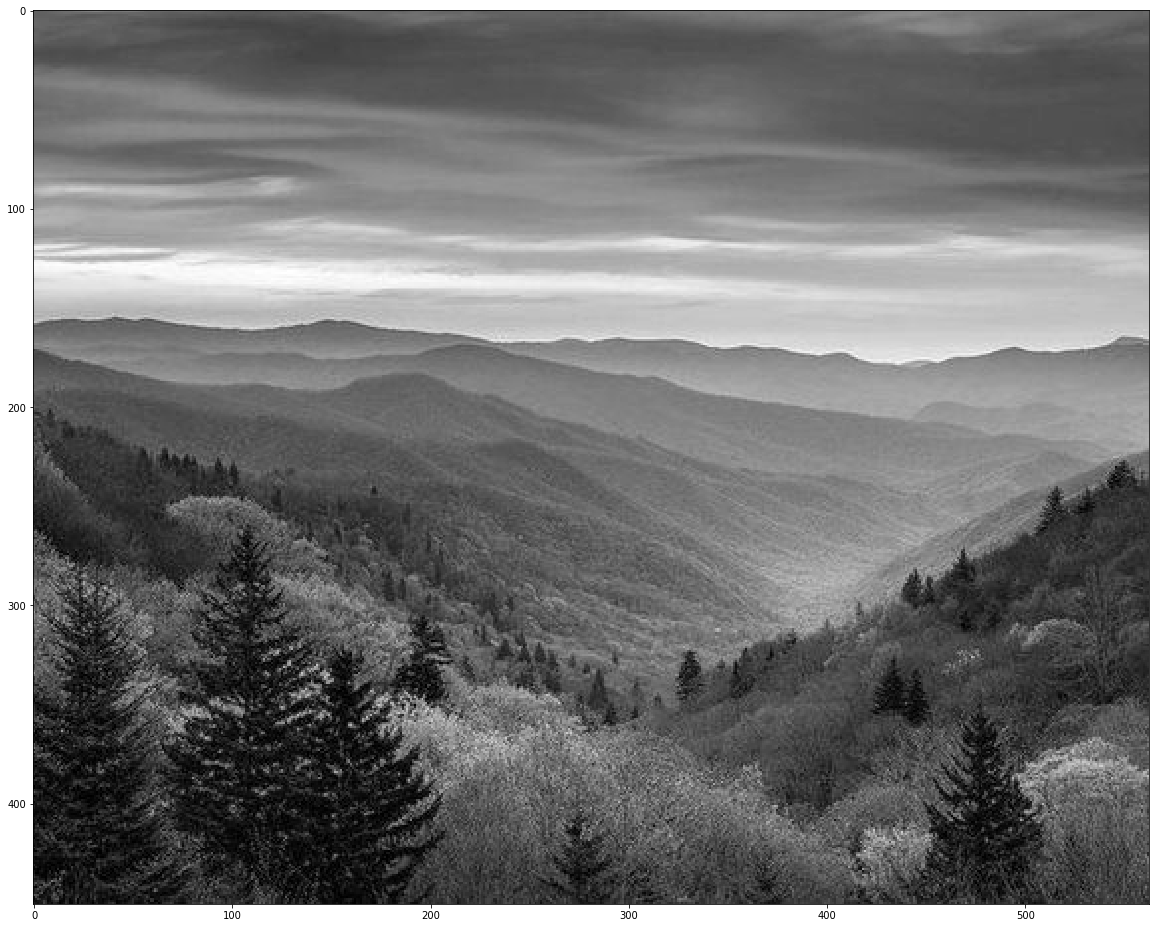

In [158]:
image = cv2.imread("../data/img5.jpg", 0)
plt.figure(figsize=(20,20))
plt.imshow(image, cmap = "gray")

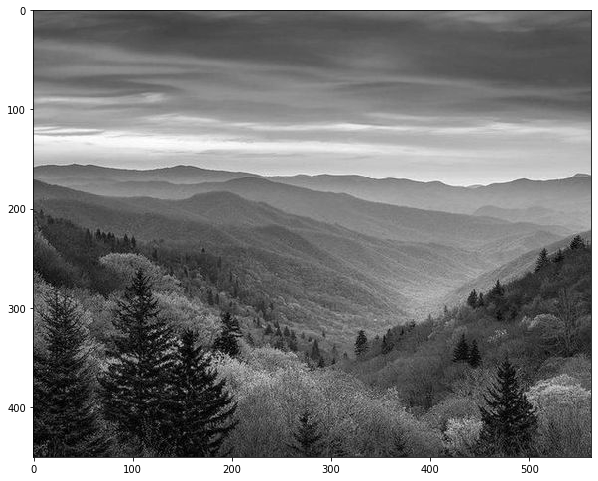

In [159]:
#image = image[250:350, 80:180]
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = "gray")

In [160]:
masks = []
allmasks = np.zeros_like((image)).astype("bool")
x,y = 0,0
allmasks.any() == False

while allmasks.all() == False:
    mask = flood(image, (x,y), tolerance=30)
    masks.append(mask)
    allmasks = np.logical_or(allmasks, mask)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if allmasks[i,j] == False:
                x,y = i, j
                break

print(len(masks))

791


In [161]:
label = np.zeros_like((image)).astype("uint32")
for i in range(len(masks)):
    # masks[i][masks[i] == True] = i
    label[masks[i] == True] = i

np.unique(label)

array([  0,   1,   2,   3,   4,   5,   6,   8,  10,  11,  12,  13,  15,
        16,  19,  20,  21,  23,  26,  28,  29,  30,  31,  32,  33,  36,
        37,  38,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  58,  59,  60,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  76,  77,  78,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  94,  95,  97,  98,  99,
       101, 102, 104, 106, 108, 111, 112, 113, 114, 115, 117, 118, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 144,
       145, 147, 149, 150, 152, 153, 155, 156, 157, 159, 164, 165, 166,
       169, 172, 174, 178, 179, 181, 182, 184, 185, 187, 188, 191, 192,
       193, 195, 196, 197, 198, 199, 202, 203, 204, 205, 206, 207, 210,
       211, 212, 213, 216, 217, 218, 219, 220, 221, 222, 227, 228, 230,
       231, 232, 237, 238, 240, 241, 242, 243, 245, 248, 250, 251, 252,
       253, 254, 255, 256, 259, 261, 262, 264, 265, 266, 267, 26

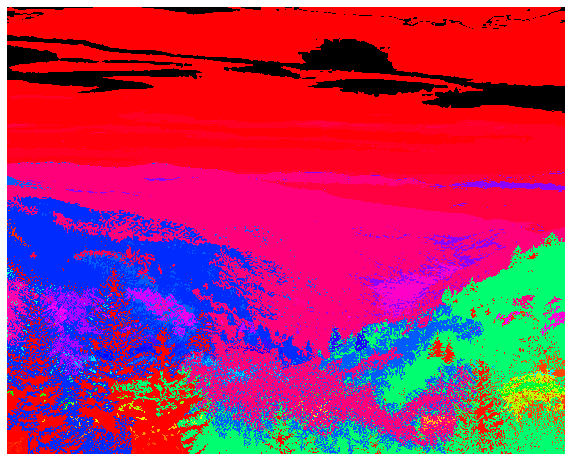

In [162]:
import colorsys
unique_vals = np.unique(label)
for val in range(len(unique_vals)):
    label[label == unique_vals[val]] = val
    
colored_label = np.zeros((image.shape[0], image.shape[1], 3))
colored_label[:, :, 0] = label
colored_label[:, :, 1] = label
colored_label[:, :, 2] = label
colored_label = colored_label.astype('uint8')


num_regions = len(np.unique(label))

for i in range(1, num_regions):
    colored_label[label == i] = np.array(colorsys.hsv_to_rgb(i / num_regions, 1, 1)) * 255

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(colored_label)

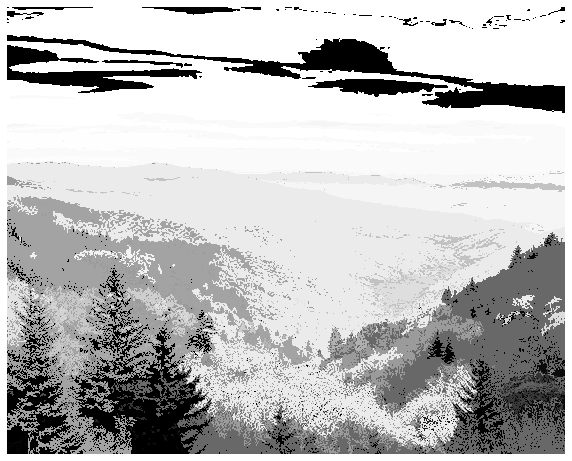

In [163]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(label, cmap="gray")

[  0   1   2   4   7   8  10  11  13  29  39  42  65  85 126 193 319 359
 360 398 404 447 481 498 505 532 572 602 617 634 652 679 689 702 715 736
 753 761 762 768 777 787 789 790 791]


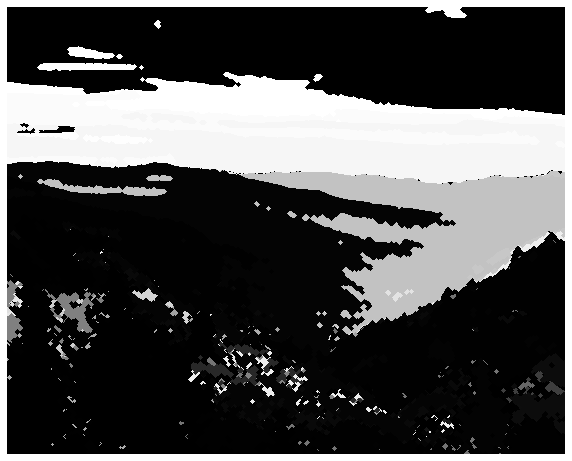

In [164]:
from skimage.morphology import disk
result = np.zeros_like(label)
i = 1
for mask in masks:
    closing = skimage.morphology.opening(mask, disk(2))
    closing = skimage.morphology.opening(closing, disk(1))
    opening = skimage.morphology.closing(closing, disk(2))
    
    temp = np.logical_and(opening, result == 0)
    result[temp] = i
    i += 1


    # hjelp, we have issue with 0 problem and need a fix
print(np.unique(result))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(result, cmap="gray")

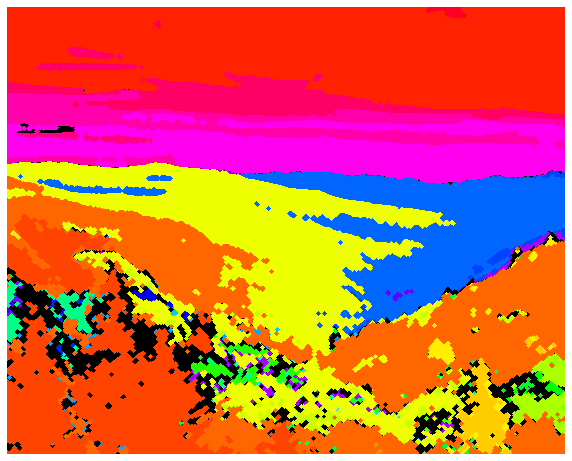

In [165]:
unique_vals = np.unique(result)
for val in range(len(unique_vals)):
    result[result == unique_vals[val]] = val

colored_result = np.zeros((image.shape[0], image.shape[1], 3))
colored_result[:, :, 0] = result
colored_result[:, :, 1] = result
colored_result[:, :, 2] = result
colored_result = colored_result.astype('uint8')


num_regions = len(np.unique(result))

for i in range(1, num_regions):
    colored_result[result == i] = np.array(colorsys.hsv_to_rgb(i / num_regions, 1, 1)) * 255

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(colored_result)

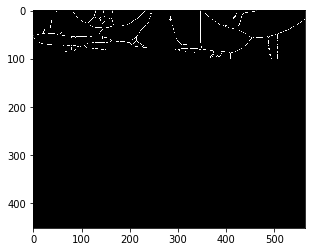

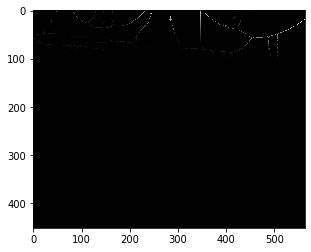

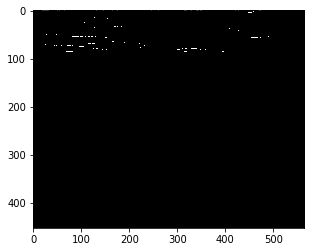

In [166]:
from skimage.morphology import medial_axis

def skeletonize(mask):
    im_th = np.asarray(mask)
    skeleton, distance_true = medial_axis(im_th, return_distance=True)

    #distance = np.floor(distance_true)
    distance = distance_true

    distance_padded = cv2.copyMakeBorder(distance, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)

    ridge_set = np.zeros_like(distance_padded)

    for i in range(1, distance.shape[0]):
        for j in range(1, distance.shape[1]):
            if (distance_padded[i, j] >= distance_padded[i-1:i+2, j-1:j+2].max()):
                ridge_set[i, j] = distance[i, j]
            else:
                ridge_set[i, j] = 0

    #ridge_set = ridge_set[1:distance.shape[0], 1:distance.shape[1]]
    ridge_set_img = ridge_set != 0

    dist_masked = distance_true * skeleton
    
    return skeleton, dist_masked, ridge_set_img, distance_padded, distance
    
skeleton, dist_masked, ridge_set_img, distance_padded, distance = skeletonize(masks[0])

plt.imshow(skeleton, cmap="gray")
plt.figure()
plt.imshow(dist_masked, cmap="gray")
plt.figure()
plt.imshow(ridge_set_img, cmap="gray")

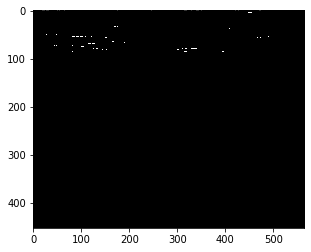

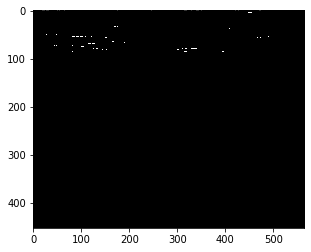

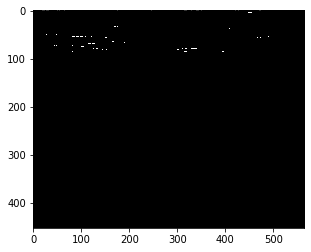

In [167]:
def thinner(ridge_set_img, distance_padded):      
    for i in range(1, distance_padded.shape[0]):
        for j in range(1, distance_padded.shape[1]):
            if (ridge_set_img[i, j] == 1):

                edge_sum = 0
                v = 0

                if(ridge_set_img[i-1, j-1] == 1):
                    v += 1
                    flag = 0
                    if(ridge_set_img[i-1, j] == 1):
                        edge_sum = edge_sum | 2**1
                        flag = 1
                    if(ridge_set_img[i, j-1] == 1):
                        edge_sum = edge_sum | 2**3
                        flag = 1

                    if (flag == 0):
                        continue

                if(ridge_set_img[i-1, j+1] == 1):
                    v += 1
                    flag = 0
                    if(ridge_set_img[i-1, j] == 1):
                        edge_sum = edge_sum | 2**2
                        flag = 1
                    if(ridge_set_img[i, j+1] == 1):
                        edge_sum = edge_sum | 2**4
                        flag = 1

                    if (flag == 0):
                        continue

                if(ridge_set_img[i+1, j-1] == 1):
                    v += 1
                    flag = 0
                    if(ridge_set_img[i, j-1] == 1):
                        edge_sum = edge_sum | 2**5
                        flag = 1
                    if(ridge_set_img[i+1, j] == 1):
                        edge_sum = edge_sum | 2**7
                        flag = 1

                    if (flag == 0):
                        continue

                if(ridge_set_img[i+1, j+1] == 1):
                    v += 1
                    flag = 0
                    if(ridge_set_img[i, j+1] == 1):
                        edge_sum = edge_sum | 2**6
                        flag = 1
                    if(ridge_set_img[i+1, j] == 1):
                        edge_sum = edge_sum | 2**8
                        flag = 1

                    if (flag == 0):
                        continue

                if(ridge_set_img[i-1, j] == 1):
                    v += 1
                    flag = 0
                    if(ridge_set_img[i-1, j-1] == 1):
                        edge_sum = edge_sum | 2**1
                        flag = 1
                    if(ridge_set_img[i-1, j+1] == 1):
                        edge_sum = edge_sum | 2**2
                        flag = 1
                    if(ridge_set_img[i, j-1] == 1):
                        edge_sum = edge_sum | 2**9
                        flag = 1
                    if(ridge_set_img[i, j+1] == 1):
                        edge_sum = edge_sum | 2**10
                        flag = 1

                    if (flag == 0):
                        continue

                if(ridge_set_img[i, j-1] == 1):
                    v += 1
                    flag = 0
                    if(ridge_set_img[i-1, j-1] == 1):
                        edge_sum = edge_sum | 2**3
                        flag = 1
                    if(ridge_set_img[i+1, j-1] == 1):
                        edge_sum = edge_sum | 2**5
                        flag = 1
                    if(ridge_set_img[i-1, j] == 1):
                        edge_sum = edge_sum | 2**9
                        flag = 1
                    if(ridge_set_img[i+1, j] == 1):
                        edge_sum = edge_sum | 2**11
                        flag = 1

                    if (flag == 0):
                        continue

                if(ridge_set_img[i, j+1] == 1):
                    v += 1
                    flag = 0
                    if(ridge_set_img[i-1, j+1] == 1):
                        edge_sum = edge_sum | 2**2
                        flag = 1
                    if(ridge_set_img[i+1, j+1] == 1):
                        edge_sum = edge_sum | 2**6
                        flag = 1
                    if(ridge_set_img[i-1, j] == 1):
                        edge_sum = edge_sum | 2**10
                        flag = 1
                    if(ridge_set_img[i+1, j] == 1):
                        edge_sum = edge_sum | 2**12
                        flag = 1

                    if (flag == 0):
                        continue

                if(ridge_set_img[i+1, j] == 1):
                    v += 1
                    flag = 0
                    if(ridge_set_img[i+1, j-1] == 1):
                        edge_sum = edge_sum | 2**7
                        flag = 1
                    if(ridge_set_img[i+1, j+1] == 1):
                        edge_sum = edge_sum | 2**8
                        flag = 1
                    if(ridge_set_img[i, j-1] == 1):
                        edge_sum = edge_sum | 2**11
                        flag = 1
                    if(ridge_set_img[i, j+1] == 1):
                        edge_sum = edge_sum | 2**12
                        flag = 1

                    if (flag == 0):
                        continue


                e = bin(edge_sum).count("1")

                if (v-1 <= e):
                    ridge_set_img[i, j] = 0
                    
    return ridge_set_img

                    
thinned_ridge = thinner(ridge_set_img, distance_padded)

plt.figure()
plt.imshow(thinned_ridge, cmap="gray")

thinned_ridge2 = thinner(thinned_ridge, distance_padded)
plt.figure()
plt.imshow(thinned_ridge2, cmap="gray")

thinned_ridge3 = thinner(thinned_ridge2, distance_padded)
plt.figure()
plt.imshow(thinned_ridge3, cmap="gray")

In [168]:
orphans = []
seeds = []
lines = []
branches = []

def nearest_nonzero_idx_v2(a,x,y):
    tmp = a[x,y]
    a[x,y] = 0
    r,c = np.nonzero(a)
    a[x,y] = tmp
    min_idx = ((r - x)**2 + (c - y)**2).argmin()
    return (r[min_idx], c[min_idx])

def return_token_recursive(thinned_ridge,token,seed):
    global orphans
    global seeds
    global lines
    global branches
    
    token.append(seed)
    thinned_ridge[seed[0], seed[1]] = 0
    lines.remove(seed)
    neighbour = nearest_nonzero_idx_v2(thinned_ridge, seed[0], seed[1])

    if (neighbour in seeds):
        token.append(neighbour)
        seeds.remove(neighbour)
        thinned_ridge[neighbour[0], neighbour[1]] = 0
        return thinned_ridge, token
    
    elif (neighbour in branches):
        token.append(neighbour)
        branches.remove(neighbour)
        lines.append(neighbour)
        return thinned_ridge, token
    
    elif (neighbour in lines):
        thinned_ridge, token = return_token_recursive(thinned_ridge, token, neighbour)
        return thinned_ridge, token
        

In [169]:
def coords(token):
    A = np.asarray(token)
#         A = res_masks[52]
    # cnt = cv2.findContours(A.astype("uint8"), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

#         M = cv2.moments(A.astype("uint8"))
#         print(M)
#         non_zeros = np.nonzero(A)
    tup = np.asarray([tuple(x) for x in A])
    vx,vy,x,y = cv2.fitLine(tup, cv2.DIST_L2,0,0.01,0.01)
#         (x,y), (Ma, ma), angle = cv2.fitEllipse(tup)


    rows, cols = A.shape[:2]
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    img = cv2.line(A.astype("uint8"),(cols-1,righty),(0,lefty),1,1)


#         cX = int(M["m10"] / M["m00"])
#         cY = int(M["m01"] / M["m00"])
#         print(cX, cY)
#         print(vx,vy, x ,y)

    return vx,vy,x,y

In [170]:
def sqDist(p1, p2):
    return ((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2)

def checkPtInCone(a, b, vx, vy, c, d, cos_alpha = 0.6):
    '''
        Check if (c,d) lies in cone generated with 
        tip at (a,b) and base of cone pointing in 
        (vx, vy) with tip angle of alpha
    '''
    
    A = [(c-a), (d-b)]
    B = [vx, vy]
    
    cos_theta = (A[0]*B[0] + A[1]*B[1])
    amodbmod = np.sqrt( sqDist(A, [0,0]) * sqDist(B, [0,0]) )
    cos_theta /= amodbmod
    return cos_theta > cos_alpha

def checkMerge(token1, token2, cos_alpha = 0.6):
    # find closest ends
    s1 = token1[0]
    e1 = token1[-1]
    s2 = token2[0]
    e2 = token2[-1]
    
    arg_close = np.argmin([
        sqDist(s1, s2),
        sqDist(s1, e2),
        sqDist(e1, s2),
        sqDist(e1, e2)
    ])
    
    closer1 = -1 * (arg_close // 2)
    closer2 = -1 * (arg_close % 2)
    
    # find distance b/w closest ends
    dist = sqDist(token1[closer1], token2[closer2])
    
    # find centre and vector of major axis of tokens
    vx1, vy1, a1, b1 = coords(token1)
    vx2, vy2, a2, b2 = coords(token2)
    
    # find vectors of closer points from centre of token
    cx1 = token1[closer1][0] - a1
    cy1 = token1[closer1][1] - b1
    cx2 = token2[closer2][0] - a2
    cy2 = token2[closer2][1] - b2
    
    # flip token vector to closer pt
    if (cx1*vx1 + cy1*vy1) < 0:
        vx1 *= -1
        vy1 *= -1
    if (cx2*vx2 + cy2*vy2) < 0:
        vx2 *= -1
        vy2 *= -1
    
    # check if ends of tokens lie in each others cones
    two_in_one = checkPtInCone(token1[closer1][0], token1[closer1][1], 
                               vx1, vy1, 
                               token2[closer2][0], token2[closer2][1], 
                               cos_alpha)
    
    one_in_two = checkPtInCone(token2[closer2][0], token2[closer2][1], 
                               vx2, vy2, 
                               token1[closer1][0], token1[closer1][1], 
                               cos_alpha)
    
    # merge tokens
    merge1 = token1[::int((closer1+0.5) * -2)]
    merge2 = token2[::int((closer2+0.5) * 2)]
    merged = merge1 + merge2
    
    return (one_in_two & two_in_one), dist, merged

In [171]:
def tokensToStrokes(tokens):
    unmerged = tokens.copy()
    strokes = []
    
    curr_stroke = unmerged[0]
    unmerged.pop(0)
    
    while unmerged:
        
        mergeable_dist = []
        mergeable_merged = []
        mergeable_indices = []
        
        for j in range(len(unmerged)):
            can_merge, dist, merged = checkMerge(unmerged[j], curr_stroke)
            if can_merge:
                mergeable_dist.append(dist)
                mergeable_merged.append(merged) 
                mergeable_indices.append(j)
        
        if mergeable_dist:         
            # append closest token to stroke and pop it
            index_to_merge = np.argmin(np.array(mergeable_dist))

            index_in_unmerged_to_pop = mergeable_indices[index_to_merge]
            curr_stroke = mergeable_merged[index_to_merge]

            unmerged.pop(index_in_unmerged_to_pop)
        else:       
            # start new stroke
            strokes.append(curr_stroke)
            curr_stroke = unmerged[0]
        
    return strokes
                # add dist and token index to list and prio and merge the token with lowest dist

In [172]:
def getradiifortoken(token):
    radii = []
    for point in np.asarray(token):
        i,j = point[0], point[1]
        radius = dist_masked[i,j]
        radii.append(np.ceil(radius))
    return radii

def getradiiformask(mask):
    pixel_radii = []
    for token in mask:
        token = np.asarray(token)
        radii = getradiifortoken(token)
        pixel_radii.append(radii)
    return pixel_radii

def drawcircle(pixels, radii, colors, img):
    x,y, radii  = pixels[0],pixels[1],radii
    colors =colors.tolist()
    image = cv2.circle(img, (x,y), int(radii),colors, -1) 
    return image

In [173]:
def get_color(stroke):
    color = image_color[stroke[0][0],stroke[0][1]]
#     color = color.astype("float") * len(stroke)
    return color

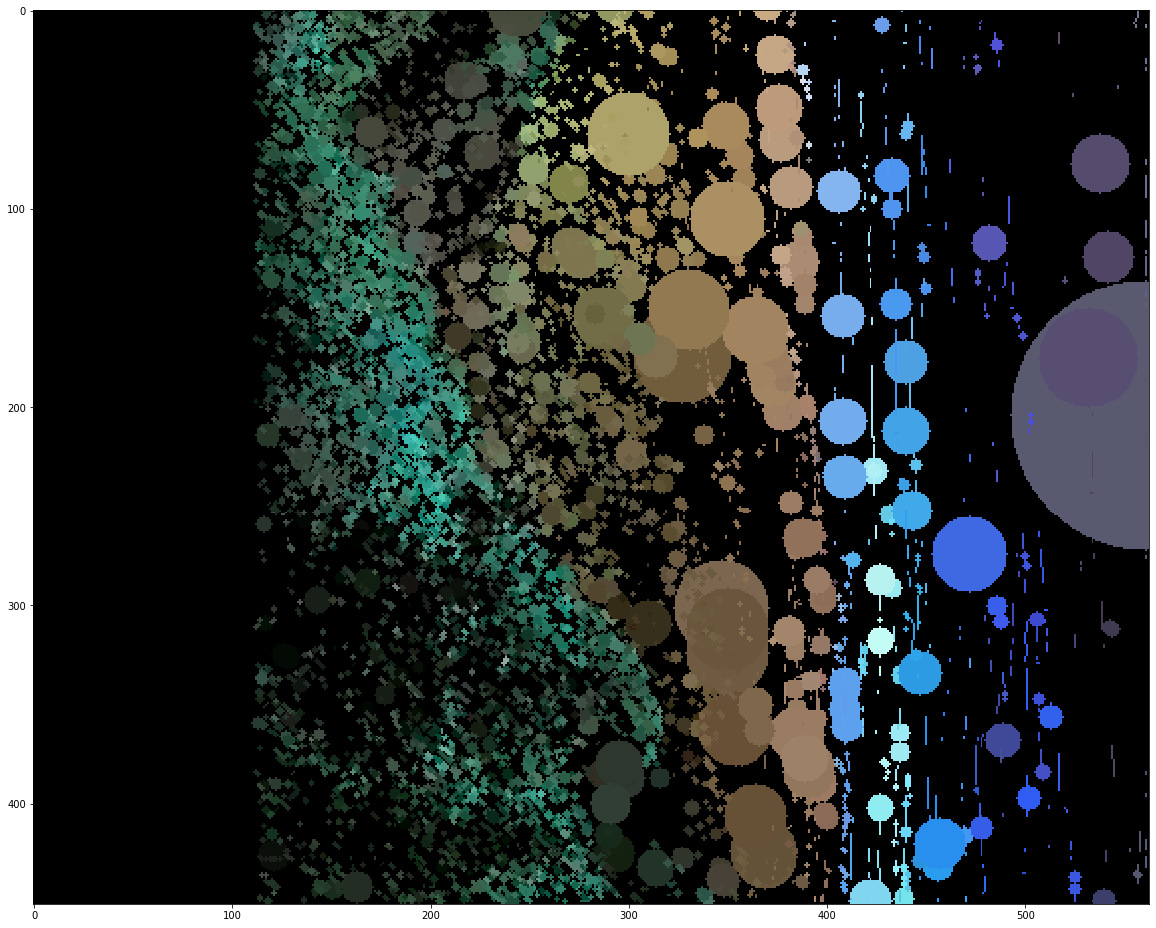

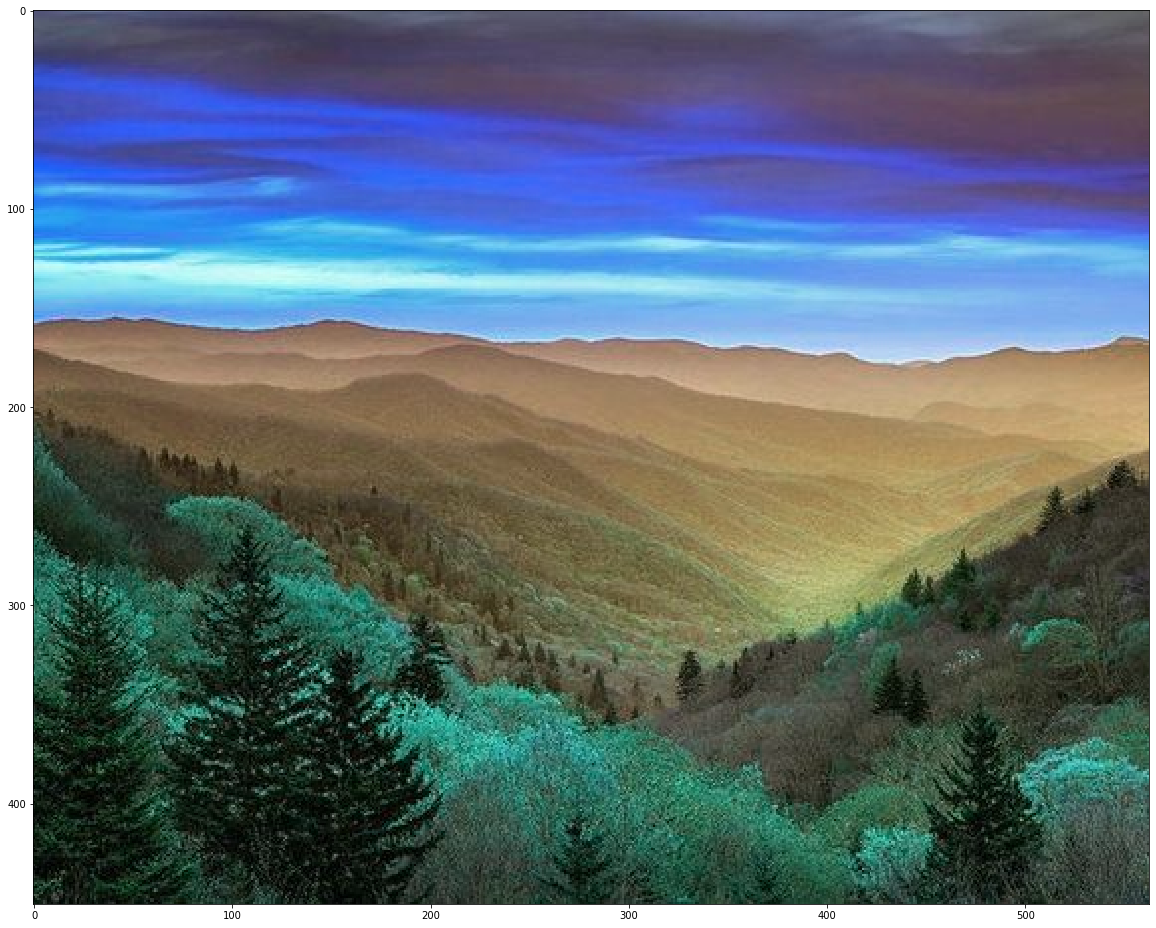

In [174]:
image_color = cv2.imread("../data/img5.jpg")
#image_color = image_color[250:350, 80:180]
rendered = np.zeros_like(image_color)

for item in masks:
#item = masks[0]

    global orphans
    global seeds
    global lines
    global branches

    orphans = []
    seeds = []
    lines = []
    branches = []

    skeleton, dist_masked, ridge_set_img, distance_padded, distance = skeletonize(item)

    thinned_img = thinner(ridge_set_img, distance_padded)
    thinned_img = thinner(thinned_img, distance_padded)
    thinned_ridge = thinner(thinned_img, distance_padded)

    for i in range(0, thinned_ridge.shape[0]):
        for j in range(0, thinned_ridge.shape[1]):
            if(thinned_ridge[i, j] == 1):
                if(thinned_ridge[i-1:i+2, j-1:j+2].sum() == 1):
                    orphans.append((i-1, j-1))
                elif(thinned_ridge[i-1:i+2, j-1:j+2].sum() == 2):
                    seeds.append((i-1, j-1))
                elif(thinned_ridge[i-1:i+2, j-1:j+2].sum() == 3):
                    lines.append((i-1, j-1))
                elif(thinned_ridge[i-1:i+2, j-1:j+2].sum() == 4):
                    branches.append((i-1, j-1))

    tokens = []
    thinned_ridge = thinned_ridge[1:distance_padded.shape[0] - 1, 1:distance_padded.shape[1] - 1]
    for seed in seeds:
        token = []
        token.append(seed)
        seeds.remove(seed)
        thinned_ridge[seed[0], seed[1]] = 0
        neighbour = nearest_nonzero_idx_v2(thinned_ridge, seed[0], seed[1])
        if (neighbour in seeds):
            token.append(neighbour)
            seeds.remove(neighbour)
            tokens.append(token)        
            thinned_ridge[neighbour[0], neighbour[1]] = 0
            continue

        elif (neighbour in branches):
            token.append(neighbour)
            branches.remove(neighbour)
            lines.append(neighbour)
            tokens.append(token)
            continue

        elif (neighbour in lines):
            thinned_ridge, token = return_token_recursive(thinned_ridge, token, neighbour)
            tokens.append(token)
            continue

    for orphan in orphans:
        token = []
        token.append(orphan)
        tokens.append(token)

    # strokes = tokensToStrokes(tokens)
    # print(strokes)
    pixels = []
    pixel_radii = []
    colors = []
    # for stroke in strokes:
    #     stroke = np.asarray(stroke)
    #     radii = getradiifortoken(stroke)
    #     pixel_radii.append(np.dstack((np.transpose(stroke)[0],np.transpose(stroke)[1],radii)))

    #     arr = get_color(stroke, pixel_radii)

    #     for pixel in stroke:
    #         rendered = drawcircle(arr, rendered)


    for token in tokens:
        token = np.asarray(token)
    #    print(token)
    #     pixels = np.concanp.concatenate((a, b), axis=0)t(pixels, token)
        radii = getradiifortoken(token)
        pixel_radii = pixel_radii + radii
        color = get_color(token)

        for i in range(len(token)):
            rendered = drawcircle(token[i], radii[i], color, rendered)
    
plt.figure(figsize=(20,20))
plt.imshow(rendered[::-1, ::-1])
plt.figure(figsize=(20,20))
plt.imshow(image_color)
    

In [179]:
plt.figure(figsize=(20,20))
temp = [[[]]]
temp[0] = np.transpose(rendered[][][0])
temp[1] = np.transpose(rendered[][][1])
temp[2] = np.transpose(rendered[][][2])
plt.imshow(temp)

SyntaxError: invalid syntax (<ipython-input-179-40a5295008eb>, line 3)